In [2]:
import numpy as np
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import arviz as az
import daft
from patsy import dmatrix

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


In [109]:
d = pd.read_csv("carbon.csv")
d = d.iloc[: , 1:]
d.head()

,Years,World Temp,Total Greenhouse Gases
0,1990,0.33,29848570
1,1991,0.33,30009210
2,1992,0.33,29879100
3,1993,0.33,29970470
4,1994,0.34,30152090


In [69]:
#Lets standardize the data
d["temp_stand"]= (d["World Temp"]- np.mean(d["World Temp"]))/np.std(d["World Temp"])
d["gases_stand"]= (d["Total Greenhouse Gases"]- np.mean(d["Total Greenhouse Gases"]))/np.std(d["Total Greenhouse Gases"])
d

,Years,World Temp,Total Greenhouse Gases,temp_stand,gases_stand
0,1990,0.33,29848570,-1.369888,-1.245395
1,1991,0.33,30009210,-1.369888,-1.217158
2,1992,0.33,29879100,-1.369888,-1.240028
3,1993,0.33,29970470,-1.369888,-1.223968
4,1994,0.34,30152090,-1.313697,-1.192043
5,1995,0.36,30839910,-1.201316,-1.071141
6,1996,0.40,31379670,-0.976553,-0.976265
7,1997,0.42,31691800,-0.864172,-0.921400
8,1998,0.44,31860170,-0.751791,-0.891805
9,1999,0.47,32018180,-0.583219,-0.864030


<Axes:>

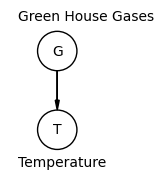

In [70]:
#Lets create the DAG

pgm = daft.PGM(dpi=100)
pgm.add_node("T","T",1,-1)
pgm.add_node("G","G",1,0)


pgm.add_text(0.50, -1.5, "Temperature")
pgm.add_text(0.50,0.35, "Green House Gases")

pgm.add_edge("G","T")

pgm.render()

In [71]:
#Now lets create a casual model 


$$
\begin{align*} T_i &\sim \text{Normal}(\mu_i, \sigma)
\\
\mu_i &=  \beta G_i  
\\
\color{black}{\beta \ } &\color{black}{\sim \text{Normal}(0,0.5)}
\\
\sigma &\sim \text{Exponential}(1) \end{align*}$$

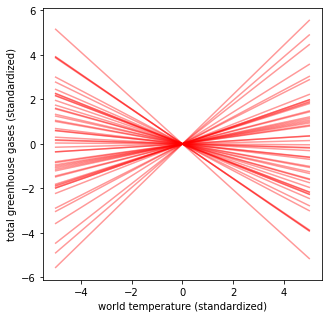

In [72]:
#Prior Predictive Analysis
with pm.Model() as model_temp:
    beta = pm.Normal('beta', mu = 0, sigma = 0.5)
    sigma = pm.Exponential('sigma',1)
    prior_pred_model_temp = pm.sample_prior_predictive()
    
Aseq = np.linspace(-5, 5, 30)
fig, ax = plt.subplots(figsize=(5,5))
for i in range(50):
    y = prior_pred_model_temp['beta'][i,] * Aseq
    ax.plot(Aseq, y, "r", alpha = 0.4) 
    ax.set_xlabel("world temperature (standardized)")
    ax.set_ylabel("total greenhouse gases (standardized)")

In [73]:
#Model itself
with pm.Model() as model_temp:
    beta = pm.Normal('beta', mu = 0, sigma = 0.5)
    sigma = pm.Exponential('sigma',1)
    mu = beta*d.gases_stand
    T = pm.Normal('T', mu = mu,  sigma = sigma, observed = d.temp_stand)
    trace_model_temp = pm.sample(1000, tune = 1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


In [74]:
az.summary(trace_model_temp, kind = "stats")    

,mean,sd,hdi_3%,hdi_97%
beta,0.945,0.057,0.838,1.055
sigma,0.303,0.042,0.226,0.383


In [75]:
az.summary(trace_model_temp, kind = "diagnostics") 

,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta,0.001,0.001,2698.0,2259.0,1.0
sigma,0.001,0.001,2815.0,2568.0,1.0


As seen above beta has a value 0.946 and it is positive. Therefore we can say that increase in total greengases and world temperature have a positive relation.



## B-Splines
Now lets do the analysis with splines. I will add years to DAG


<Axes:>

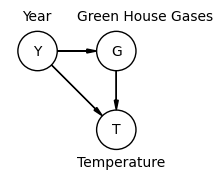

In [76]:
pgm = daft.PGM(dpi=100)
pgm.add_node("T","T",1,-1)
pgm.add_node("G","G",1,0)
pgm.add_node("Y","Y",0,0)

pgm.add_text(0.50, -1.5, "Temperature")
pgm.add_text(0.50,0.35, "Green House Gases")
pgm.add_text(-0.20, 0.35, "Year")

pgm.add_edge("G","T")
pgm.add_edge("Y","T")
pgm.add_edge("Y","G")

pgm.render()

1.First, I will draw splines for years and world temperature

$$
\begin{align*} T_i &\sim \text{Normal}(\mu_i, \sigma)
\\
\mu_i &=  \alpha + \sum_{k=1}^{K} w_kB_{k,i}
\\
\color{black}{\alpha \ } &\color{black}{\sim \text{Normal}(0,1)}
\\
\color{black}{w_j \ } &\color{black}{\sim \text{Normal}(0,1)}
\\
\sigma &\sim \text{Exponential}(1) \end{align*}$$

In [81]:
num_knots = 8

knot_list = np.quantile(d.Years, np.linspace(0, 1, num_knots))

In [82]:
B = dmatrix(
    "bs(year, knots=knots, degree=3, include_intercept=True) - 1",
    {"year": d.Years.values, "knots": knot_list[1:-1]},
)

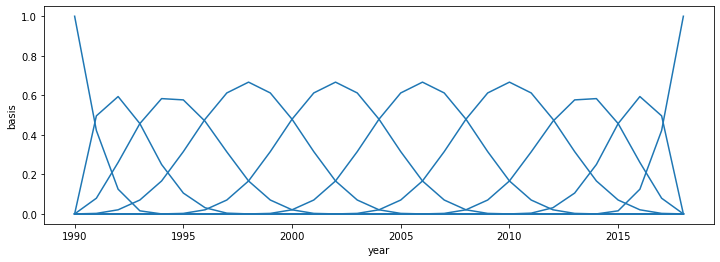

In [83]:
_, ax = plt.subplots(1, 1, figsize=(12, 4))
for i in range(10):
    ax.plot(d.Years, (B[:, i]), color="C0")
ax.set_xlabel("year")
ax.set_ylabel("basis");

In [85]:
with pm.Model() as model_tep_year:
    a = pm.Normal("a", 0, 11)
    w = pm.Normal("w", mu=0, sigma=1, shape=B.shape[1])
    mu = pm.Deterministic("mu", a + pm.math.dot(np.asarray(B, order="F"), w.T))
    sigma = pm.Exponential("sigma", 1)
    T = pm.Normal("T", mu, sigma, observed=d.temp_stand)
    trace_model_temp_year = pm.sample(1000, tune = 1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, w, a]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.
There were 293 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6886434662085658, but should be close to 0.8. Try to increase the number of tuning steps.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
There were 135 divergences after tuning. Increase `target_accept` or reparameterize.
There were 340 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6646676111179505, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


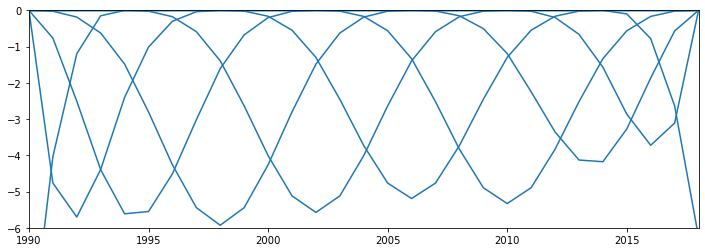

In [17]:
_, ax = plt.subplots(1, 1, figsize=(12, 4))
wp = trace_model_temp_year.posterior.w.mean(dim=["chain", "draw"])
for i in range(10):
    ax.plot(d.Years, (wp[i].item(0) * B[:, i]), color="C0")
ax.set_xlim(1990, 2018)
ax.set_ylim(-6, 0);

Text(0, 0.5, 'temps')

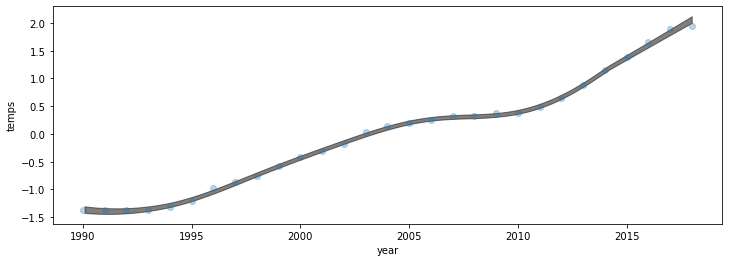

In [19]:
ax = az.plot_hdi(d.Years, trace_model_temp_year.posterior["mu"], color="k")
ax.plot(d.Years, d.temp_stand, "o", alpha=0.3)
fig = plt.gcf()
fig.set_size_inches(12, 4)
ax.set_xlabel("year")
ax.set_ylabel("temps")

2.Second, I will draw splines for years and greenhouse gases

$$
\begin{align*} G_i &\sim \text{Normal}(\mu_i, \sigma)
\\
\mu_i &=  \alpha + \sum_{k=1}^{K} w_kB_{k,i}
\\
\color{black}{\alpha \ } &\color{black}{\sim \text{Normal}(0,1)}
\\
\color{black}{w_j \ } &\color{black}{\sim \text{Normal}(0,1)}
\\
\sigma &\sim \text{Exponential}(1) \end{align*}$$

In [98]:
num_knots = 8

knot_list = np.quantile(d.Years, np.linspace(0, 1, num_knots))

In [99]:
B = dmatrix(
    "bs(year, knots=knots, degree=3, include_intercept=True) - 1",
    {"year": d.Years.values, "knots": knot_list[1:-1]},
)

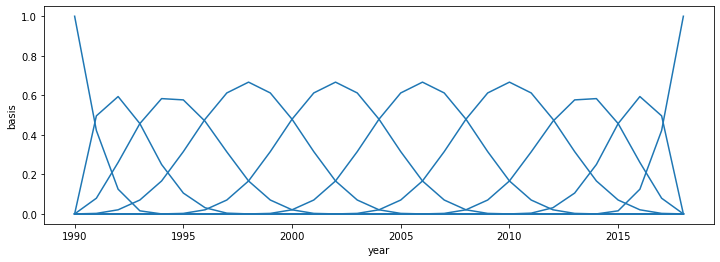

In [100]:
_, ax = plt.subplots(1, 1, figsize=(12, 4))
for i in range(10):
    ax.plot(d.Years, (B[:, i]), color="C0")
ax.set_xlabel("year")
ax.set_ylabel("basis");

In [84]:
with pm.Model() as model_gas_year:
    a = pm.Normal("a", 0, 1)
    w = pm.Normal("w", mu=0, sigma=1, shape=B.shape[1])
    mu = pm.Deterministic("mu", a + pm.math.dot(np.asarray(B, order="F"), w.T))
    sigma = pm.Exponential("sigma", 1)
    G = pm.Normal("G", mu, sigma, observed=d.gases_stand)
    trace_model_gas_year = pm.sample(1000, tune = 1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, w, a]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9056386402777039, but should be close to 0.8. Try to increase the number of tuning steps.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.882429458974192, but should be close to 0.8. Try to increase the number of tuning steps.
There were 99 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


Text(0, 0.5, 'Gases')

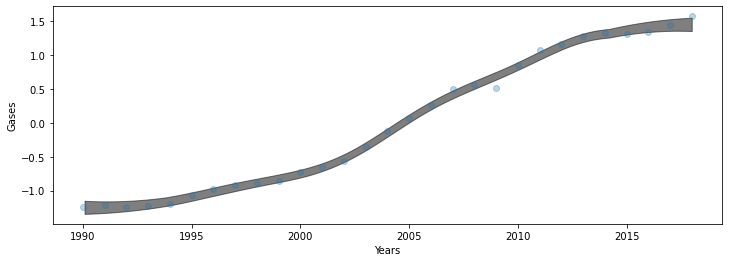

In [86]:
ax = az.plot_hdi(d.Years, trace_model_gas_year.posterior["mu"], color="k")
ax.plot(d.Years, d.gases_stand, "o", alpha=0.3)
fig = plt.gcf()
fig.set_size_inches(12, 4)
ax.set_xlabel("Years")
ax.set_ylabel("Gases")

3.Now, I will draw splines for world temperature and greenhouse gases


$$
\begin{align*} T_i &\sim \text{Normal}(\mu_i, \sigma)
\\
\mu_i &=  \alpha + \sum_{k=1}^{K} w_kB_{k,i}
\\
\color{black}{\alpha \ } &\color{black}{\sim \text{Normal}(0,1)}
\\
\color{black}{w_j \ } &\color{black}{\sim \text{Normal}(0,1)}
\\
\sigma &\sim \text{Exponential}(1) \end{align*}$$

In [101]:
num_knots = 5

knot_list = np.quantile(d.gases_stand, np.linspace(0, 1, num_knots))

In [102]:
B = dmatrix(
    "bs(year, knots=knots, degree=3, include_intercept=True) - 1",
    {"year": d.gases_stand.values, "knots": knot_list[1:-1]},
)

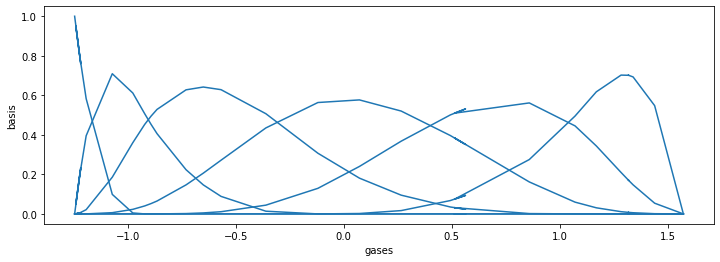

In [103]:
_, ax = plt.subplots(1, 1, figsize=(12, 4))
for i in range(6):
    ax.plot(d.gases_stand, (B[:, i]), color="C0")
ax.set_xlabel("gases")
ax.set_ylabel("basis");

In [104]:
with pm.Model() as model_gas_temp:
    a = pm.Normal("a", 0, 1)
    w = pm.Normal("w", mu=0, sigma=1, shape=B.shape[1])
    mu = pm.Deterministic("mu", a + pm.math.dot(np.asarray(B, order="F"), w.T))
    sigma = pm.Exponential("sigma", 1)
    T = pm.Normal("T", mu, sigma, observed=d.temp_stand)
    trace_model_gas_temp = pm.sample(1000, tune = 1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, w, a]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 130 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7152627566518232, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


Text(0, 0.5, 'World Temperature')

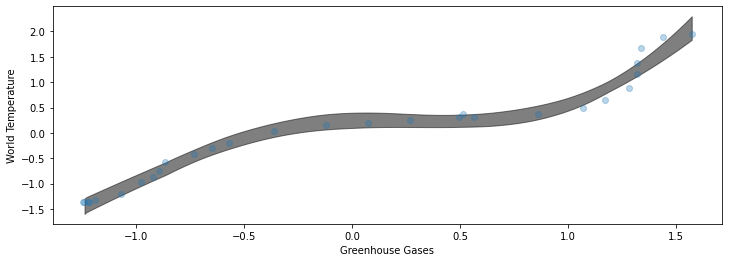

In [105]:
ax = az.plot_hdi(d.gases_stand, trace_model_gas_temp.posterior["mu"], color="k")
ax.plot(d.gases_stand, d.temp_stand, "o", alpha=0.3)
fig = plt.gcf()
fig.set_size_inches(12, 4)
ax.set_xlabel("Greenhouse Gases")
ax.set_ylabel("World Temperature")

Finally, model comparison between simple regression and B-Spline method for world temperature and greenhouse gas.


In [108]:
compare_waic = az.compare({'$SPLINE$':trace_model_gas_temp, '$SIMPLE$':trace_model_temp},scale="deviance",
    ic = "waic")
compare_waic

/opt/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/arviz/stats/stats.py:1635: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
$SPLINE$,0,-20.620722,6.634682,0.000000,1.000000e+00,9.658008,0.000000,True,deviance
$SIMPLE$,1,13.609608,1.664119,34.230329,3.783640e-13,5.522443,7.956424,False,deviance
